# KNN evaluation
Compare the accuracy and time required for the forecast for an increasing number of n_neighbors

## Preparation
- Imports
- Data preprocessing
- Feature and target encoding

In [1]:
from pandas import DataFrame
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import seaborn as sns

from datetime import datetime
from datetime import timedelta

df = pd.read_csv('../data/DEvideos.csv',
    low_memory=False)

df['trending_date'] = df.apply(lambda row: datetime.strptime(row['trending_date'], '%y.%d.%m'), axis=1)
df['publish_time'] = df.apply(lambda row: datetime.strptime(row['publish_time'], '%Y-%m-%dT%H:%M:%S.000Z'), axis=1)
df['days_until_trending'] = df.apply(lambda row: ((row['trending_date'] - row['publish_time']).days + 1), axis=1)

df['tags_count'] = df.apply(lambda row: len(row['tags'].split('|')), axis=1)
df['publish_hour'] = df['publish_time'].map(lambda x: x.hour)
df['publish_month'] = df['publish_time'].map(lambda x: x.month)
df['publish_year'] = df['publish_time'].map(lambda x: x.year)
df['publish_day_of_month'] = df['publish_time'].map(lambda x: x.day)
df['publish_weekday'] = df['publish_time'].map(lambda x: x.weekday()) # 0: Monday, 6: Sunday

df['like_dislike_ratio'] = df.apply(lambda row: row['likes'] / (row['dislikes'] + 1), axis=1)
df['like_view_ratio'] = df.apply(lambda row: row['likes'] / (row['views'] + 1), axis=1)

df['ratings'] = df['likes'] + df['dislikes']
df['likes_per_rating'] = df.apply(lambda row: 0 if row['ratings'] == 0 else row['likes'] / row['ratings'], axis=1)
df['ratings_per_view'] = df['ratings'] / df['views']
df['comments_per_view'] = df['comment_count'] / df['views']

def assign_target_category(row):
    if row['days_until_trending'] == 0: 
        return 0
    elif row['days_until_trending'] == 1:
        return 1
    elif row['days_until_trending'] == 2:
        return 2
    elif row['days_until_trending'] <= 5:
        return 3
    else:
        return 6

df['target_category'] = df.apply(assign_target_category, axis=1)
df['channel_title'] = df['channel_title'].astype('category')

tag_df = pd.read_csv('../data/tags.csv')
tag_df = tag_df.set_index('tag')
def calculate_tag_factor(tag_string, tag_data):
    tag_list = pd.Series(list(set(map(lambda x: x.strip('\"').lower(), tag_string.split('|')))))
    return tag_list.apply(lambda tag: tag_data['factor'].get(tag, np.nan)).mean(skipna=True)
    
df['tag_factors'] = df['tags'].apply(lambda x: calculate_tag_factor(x, tag_df))
df['tag_factors'] = df.apply(lambda row: 0 if np.isnan(row['tag_factors']) else row['tag_factors'], axis=1)

N = len(df)
dropColumns = ['video_id', 'title', 'tags', 'thumbnail_link', 'description']
for column in df.columns:
    numberOfUniqueValues = df[column].nunique()
    if numberOfUniqueValues < 2:
        dropColumns.append(column)
    elif df[column].dtype == 'object' and numberOfUniqueValues > N * 0.9:
        dropColumns.append(column)
    elif df[column].isna().sum() / N > 0.95:
        dropColumns.append(column)
        
df.drop(columns=dropColumns, inplace=True)

x_df = DataFrame(index=df.index)
features = ['views', 'publish_hour', 'ratings_per_view', 'comments_per_view', 'tag_factors']
for feature in features:
    feature_data = df[feature]
    if df[feature].dtype.name == 'category':
        x_label_encoder = preprocessing.LabelEncoder()
        x_label_encoder.fit(feature_data.astype(str))
        x_df[feature] = x_label_encoder.transform(feature_data)
    elif df[feature].dtype.name == 'datetime64[ns]':
        x_df[feature] = feature_data.to_seconds()
    elif df[feature].dtype.name == 'bool':
        x_df[feature] = int(feature_data)
    else:
        x_df[feature] = feature_data

x = np.reshape(x_df, (-1, len(x_df.columns)))

target = df['target_category'].astype(str)
y_label_encoder = preprocessing.LabelEncoder()
y_label_encoder.fit(target)
y = y_label_encoder.transform(target)

In [65]:
%%time
knn_model = KNeighborsClassifier()
optimization_dict = {'n_neighbors': [5, 10, 20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 6000, 7000, 8000, 9000, 10000]}

model = GridSearchCV(knn_model, optimization_dict, scoring='accuracy', n_jobs=-1)

model.fit(x,y)
print(model.best_score_)
print(model.best_params_)

0.6350881488736533
{'n_neighbors': 300}
Wall time: 57.1 s


In [66]:
results = pd.DataFrame()
results['mean_fit_time'] = model.cv_results_.get('mean_fit_time')
results['mean_score_time'] = model.cv_results_.get('mean_score_time')
results['params'] = model.cv_results_.get('params')
results['n_neighbors'] = results.apply(lambda row: row['params'].get('n_neighbors'), axis=1)
results['mean_test_score'] = model.cv_results_.get('mean_test_score')
results['rank_test_score'] = model.cv_results_.get('rank_test_score')
results

,mean_fit_time,mean_score_time,params,n_neighbors,mean_test_score,rank_test_score
0,0.100999,0.320799,{'n_neighbors': 5},5,0.586312,38
1,0.115598,0.311601,{'n_neighbors': 10},10,0.604212,37
2,0.098799,0.338401,{'n_neighbors': 20},20,0.617287,36
3,0.106400,0.347998,{'n_neighbors': 40},40,0.627326,27
4,0.104999,0.366600,{'n_neighbors': 60},60,0.630118,24
5,0.106799,0.378401,{'n_neighbors': 80},80,0.632444,20
6,0.097599,0.370800,{'n_neighbors': 100},100,0.633154,19
7,0.098599,0.439400,{'n_neighbors': 150},150,0.633864,18
8,0.102800,0.510400,{'n_neighbors': 200},200,0.634354,6
9,0.098598,0.560602,{'n_neighbors': 250},250,0.634696,3


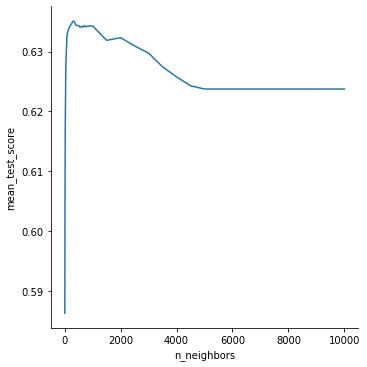

In [67]:
sns.relplot(data=results, x='n_neighbors', y='mean_test_score', kind='line')

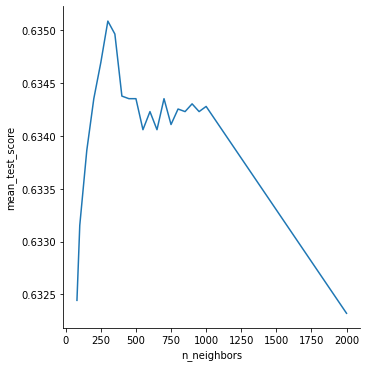

In [68]:
sns.relplot(data=results[results['mean_test_score'] > 0.632], x='n_neighbors', y='mean_test_score', kind='line')